# 🧠 Clasificador de Estado de Salud con PyTorch

Este proyecto utiliza una red neuronal profunda (MLP) implementada en PyTorch para clasificar el estado de salud de pacientes en tres categorías: **mala**, **regular** o **buena**, usando un conjunto de datos tabulares.

---


## Importar librerias

In [1]:
# Manejo de datos
import numpy as np
import pandas as pd
import random
import os

# Modelos de Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#Preprocesamiento de datos
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Gráficos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version torch: {torch.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")
print(f"{color}- Version sklearn: {pd.__version__}")

Versión de las librerias utilizadas:
- Version torch: 2.7.1+cpu
- Version pandas: 2.2.3
- Version numpy: 2.2.6
- Version sklearn: 2.2.3


## Lectura del dataset

In [ ]:
try:
    # 1. Cargar el nuevo dataset multiclase
    data = pd.read_csv('Datasets/datasetMulti.csv')
    print("Archivo cargado correctamente.")
except Exception as e:
    print(f"Error: {e}")

Archivo cargado correctamente.


In [3]:
data.head(5)

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [4]:
# Eliminar columnas de identificación
data = data.drop(columns=['ID', 'No_Pation'])

# 2. Mapear la columna objetivo 'CLASS' a valores numéricos
class_mapping = {'N': 0, 'P': 1, 'Y': 2}
data['CLASS'] = data['CLASS'].map(class_mapping)

# Convertir la variable categórica 'Gender' a numérica
data = pd.get_dummies(data, columns=['Gender'], drop_first=True)

# Eliminar filas con valores nulos si los hubiera
data.dropna(inplace=True)

# Renombrar columnas para que no tengan caracteres especiales
data.columns = data.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

print("Preprocesamiento listo. Nuevas columnas:")
print(data.columns)
data.head()

Preprocesamiento listo. Nuevas columnas:
Index(['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI',
       'CLASS', 'Gender_M', 'Gender_f'],
      dtype='object')


,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS,Gender_M,Gender_f
0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0.0,False,False
1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,0.0,True,False
2,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0.0,False,False
3,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0.0,False,False
4,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,0.0,True,False


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 995 entries, 0 to 995
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AGE       995 non-null    int64  
 1   Urea      995 non-null    float64
 2   Cr        995 non-null    int64  
 3   HbA1c     995 non-null    float64
 4   Chol      995 non-null    float64
 5   TG        995 non-null    float64
 6   HDL       995 non-null    float64
 7   LDL       995 non-null    float64
 8   VLDL      995 non-null    float64
 9   BMI       995 non-null    float64
 10  CLASS     995 non-null    float64
 11  Gender_M  995 non-null    bool   
 12  Gender_f  995 non-null    bool   
dtypes: bool(2), float64(9), int64(2)
memory usage: 95.2 KB


In [6]:
seed = 110425
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [ ]:
print("--- Distribución de clases en el dataset completo (antes de SMOTE) ---")
print(data['CLASS'].value_counts())
print("-" * 50)

# 2. Separar características (x) y objetivo (y)
x = data.drop(columns=["CLASS"]).to_numpy()
y = data["CLASS"].to_numpy()

# 3. Dividir en conjuntos de entrenamiento, validación y prueba ANTES de SMOTE
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y) # 20% para test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train) # 15% del resto para validación

# 4. Aplicar el escalado
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val) # Usar el mismo scaler del train
X_test = scaler.transform(X_test) # Usar el mismo scaler del train

# 5. Aplicar SMOTE SÓLO al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("--- Distribución de clases DESPUÉS de SMOTE ---")
print("Entrenamiento (balanceado):")
print(pd.Series(y_train_smote).value_counts())
print("\nValidación (original, no balanceado):")
print(pd.Series(y_val).value_counts())
print("-" * 50)

# 6. Renombrar las variables para que el resto del código funcione
X_train, y_train = X_train_smote, y_train_smote


--- Distribución de clases en el dataset completo (antes de SMOTE) ---
CLASS
2.0    840
0.0    102
1.0     53
Name: count, dtype: int64
--------------------------------------------------
--- Distribución de clases DESPUÉS de SMOTE ---
Entrenamiento (balanceado):
0.0    571
2.0    571
1.0    571
Name: count, dtype: int64

Validación (original, no balanceado):
2.0    101
0.0     13
1.0      6
Name: count, dtype: int64
--------------------------------------------------


In [ ]:
#Train
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

#Val
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

#Test
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [9]:
batchsize = 32
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = DiabetesDataset(X_train, y_train)
val_data = DiabetesDataset(X_val, y_val)
test_data = DiabetesDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=False)

In [10]:
len(train_data)

1713

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hc1 = nn.Linear(x.shape[1], 256) # Ajuste automático al número de columnas
        self.hc2 = nn.Linear(256, 128)
        self.hc3 = nn.Linear(128, 64)
        # 4. Ajustar la capa de salida a 3 neuronas para la clasificación multiclase
        self.hc4 = nn.Linear(64, 3) 
        self.act = nn.LeakyReLU()
        self.dp1 = nn.Dropout(0.4)
        self.dp2 = nn.Dropout(0.2)

    def forward(self, input):
        l1 = self.dp1(self.act(self.hc1(input)))
        l2 = self.dp2(self.act(self.hc2(l1)))
        l3 = self.act(self.hc3(l2))
        output = self.hc4(l3)
        return output

In [12]:
testeo = MLP()
lr = 1e-4
opt = torch.optim.SGD(testeo.parameters(), lr=lr, weight_decay=1e-4)
loss_func = nn.CrossEntropyLoss()


In [13]:
lambda_l1 = 1e-3
def l1_penalty(model):
    l1 = 0.0
    for param in model.parameters():
        if param.requires_grad and len(param.shape) > 1:
            l1 += torch.norm(param, p=1)
    return l1

In [14]:
#Entrenamiento

n_epochs = 2000
history = {
    "TL" : [],
    "VL" : []
}
early_stopping = {
    "delta" : 1e-5,
    "patience": 50
}
best_val_loss = float("inf")
aux = 0

for i in range(n_epochs+1):
    testeo.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:  
      output = testeo(X_batch)
      loss = loss_func(output, y_batch)  #+ l1_penalty(testeo) *lambda_l1
      
      opt.zero_grad()
      loss.backward()
      opt.step()

      epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    history["TL"].append(epoch_loss)

    testeo.eval()
    epoch_loss = 0
    for X_batch, y_batch in val_loader:
      with torch.no_grad():
        preds_val = testeo(X_batch)
      val_loss = loss_func(preds_val, y_batch)

      epoch_loss += val_loss.item()
    epoch_loss /= len(val_loader)
    history["VL"].append(epoch_loss)
    
    if epoch_loss + early_stopping["delta"] < best_val_loss:
      best_val_loss = epoch_loss
      aux = 0
      print(f"Reinicio aux en epoch {i}")
    else:
      aux += 1
      if aux >= early_stopping["patience"]:
        print(f"Terminando el entrenamiento en la época {i}")
        break
    

Reinicio aux en epoch 0
Reinicio aux en epoch 1
Reinicio aux en epoch 2
Reinicio aux en epoch 3
Reinicio aux en epoch 4
Reinicio aux en epoch 5
Reinicio aux en epoch 6
Reinicio aux en epoch 7
Reinicio aux en epoch 8
Reinicio aux en epoch 9
Reinicio aux en epoch 10
Reinicio aux en epoch 11
Reinicio aux en epoch 12
Reinicio aux en epoch 13
Reinicio aux en epoch 14
Reinicio aux en epoch 15
Reinicio aux en epoch 16
Reinicio aux en epoch 17
Reinicio aux en epoch 18
Reinicio aux en epoch 19
Reinicio aux en epoch 20
Reinicio aux en epoch 21
Reinicio aux en epoch 22
Reinicio aux en epoch 23
Reinicio aux en epoch 24
Reinicio aux en epoch 25
Reinicio aux en epoch 26
Reinicio aux en epoch 27
Reinicio aux en epoch 28
Reinicio aux en epoch 29
Reinicio aux en epoch 30
Reinicio aux en epoch 31
Reinicio aux en epoch 32
Reinicio aux en epoch 33
Reinicio aux en epoch 34
Reinicio aux en epoch 35
Reinicio aux en epoch 36
Reinicio aux en epoch 37
Reinicio aux en epoch 38
Reinicio aux en epoch 39
Reinicio a

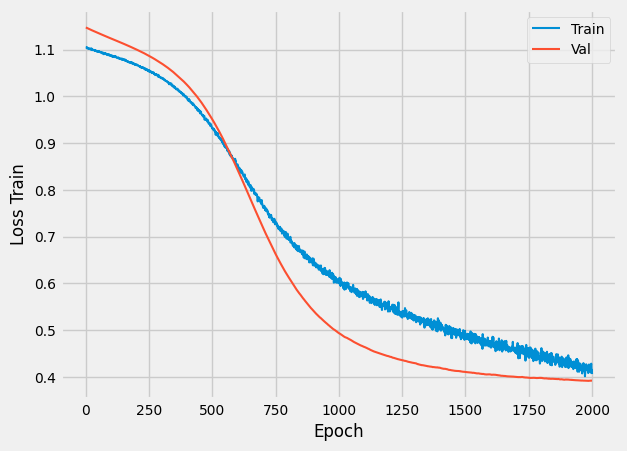

In [15]:

plt.plot(history["TL"], label="Train")
plt.plot(history["VL"], label="Val")
plt.xlabel('Epoch')
plt.ylabel('Loss Train')
plt.legend()
plt.show()

In [16]:
#Train
with torch.no_grad():
    output_train = testeo(X_train)
y_hat_train = output_train.numpy()
y_hat_train = [np.argmax(i) for i in y_hat_train]
print(f'Training Accuracy: {accuracy_score(y_train, y_hat_train):.2f}')
#Testeo
with torch.no_grad():
    output = testeo(X_test)  
y_hat = output.numpy()
y_hat = [np.argmax(i) for i in y_hat]
print(f'Testing Accuracy: {accuracy_score(y_test, y_hat):.2f}')

Training Accuracy: 0.90
Testing Accuracy: 0.93


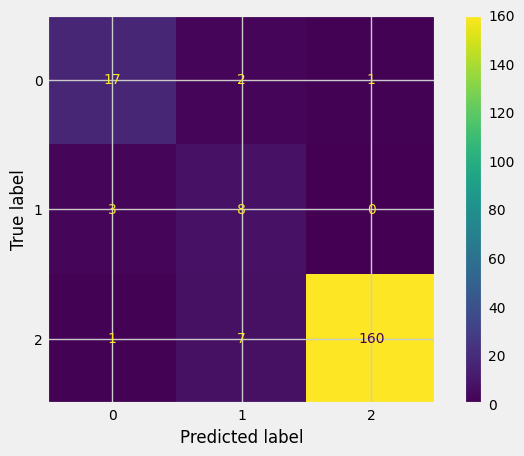

In [17]:
cm =confusion_matrix(y_test, y_hat)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_plot.plot()
plt.show()